# Convergence

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)

In [2]:
os.chdir('../src')

Model definition

In [3]:
from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


In [4]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [5]:
nfe = 200 #
seeds = 2
run_comment = 'HPCtest1'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\HPCtest1_200nfe_2seed'

Change the load archives method of the ArchiveLogger class

In [6]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [7]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

In [8]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


In [9]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [10]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.8] * len(model.outcomes), problem)  # [0.05]
print('reference_set', reference_set)
print('reference_set type is', type(reference_set))

reference_set          v0        v1        v2        v3        v4        v5        v6  \
0 -0.325469 -0.577795 -0.175057 -0.448714 -0.578928 -0.085247  0.726441   
1  0.231317  0.004498  0.833010  0.092232 -0.088696  0.415264  0.835388   
2 -1.000000  0.434930  0.806612  0.013797  0.173865  0.153885 -0.188325   
3  0.233911 -0.361372 -0.390672 -0.851481 -0.095891  0.670568  0.136934   
4  0.107047 -1.000000 -1.000000  0.551301  0.537492  0.418799 -0.316820   
5  0.217190  0.082346  0.157060  0.236828 -0.089487  0.123352 -0.005203   
6 -0.154739 -0.010442 -0.307944 -0.068954 -0.064165 -0.000049  0.006625   

         v7        v8        v9  ...      v223      v224      v225      v226  \
0  0.414060 -0.264437 -0.637177  ...  0.543476 -0.812506  0.627552 -0.145285   
1 -0.427779  0.612264  0.980438  ...  0.117421  0.439603 -0.389140 -0.671116   
2  0.329232  0.221989 -0.058193  ... -1.000000 -0.475153  1.000000 -0.358205   
3 -0.454027  0.445447 -0.363317  ... -0.882609  0.840847  0.96978

In [11]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [12]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)

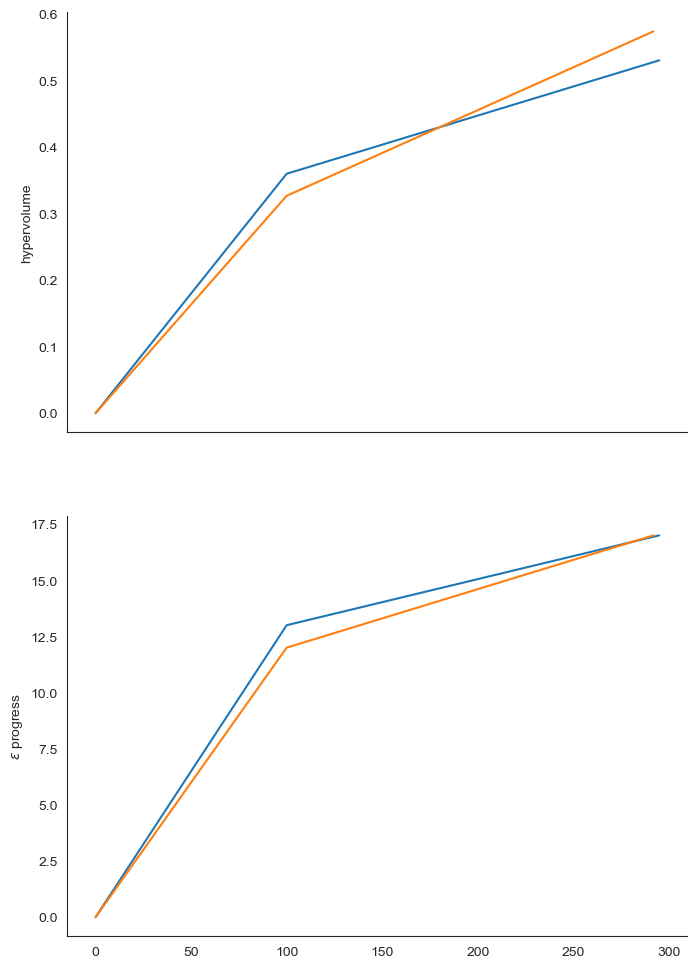

In [13]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()

In [14]:
print(metrics_by_seed)

[   hypervolume  nfe
0     0.000000    0
1     0.359602  100
2     0.529927  295,    hypervolume  nfe
0     0.000000    0
1     0.326479  100
2     0.573456  292]
